In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import pandas as pd
import seaborn as sns
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Data Sets
1. AT&T faces (Modified)
2. Omniglot (Single language - Gujarati)

Datasets

In [2]:
dataset = 2
# Load the training dataset
if dataset == 1:
    folder_dataset = datasets.ImageFolder(root=r"data\faces\training")
    folder_dataset_test = datasets.ImageFolder(root=r"data\faces\testing/")
    print(f"Dataset: AT&T faces (Modified)\n")
elif dataset == 2:
    folder_dataset = datasets.ImageFolder(root=r"data\Gujarati\training")
    folder_dataset_test = datasets.ImageFolder(root=r"data\Gujarati\testing/")
    print(f"Dataset: Omniglot (Single language - Gujarati)\n")

d_no_epochs = 25
d_batch_size = 30
d_margin = 2.0
d_latent = 128
print(f"Summary of Training Folder:\n {folder_dataset}\n")
print(f"Summary of Testing Folder:\n {folder_dataset_test}")

# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                        transforms.ToTensor()
                                        ])

Dataset: Omniglot (Single language - Gujarati)

Summary of Training Folder:
 Dataset ImageFolder
    Number of datapoints: 760
    Root location: data\Gujarati\training

Summary of Testing Folder:
 Dataset ImageFolder
    Number of datapoints: 200
    Root location: data\Gujarati\testing/


In [3]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

Siamese Neural Network: CNN + FC

In [4]:
#create the Siamese Neural Network
torch.manual_seed(42)
class SiameseNetwork(nn.Module):

    def __init__(self,latent):
        super(SiameseNetwork, self).__init__()
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,latent)
        )

    def forward_once(self, x):
        # This function will be called for each images
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, anchor, positive, negative):
        # In this function we pass in given images and obtain laten space embeddings
        output_anchor = self.forward_once(anchor)
        output_positive = self.forward_once(positive)
        output_negative = self.forward_once(negative)

        return output_anchor, output_positive, output_negative

Dataset loader

In [5]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None,test=False):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.test = test
        self.files = iter(self.imageFolderDataset.imgs)
        self.firstexec = True
        self.current_file = next(self.files)
        random.seed(42)

    def __getitem__(self,index):
        if not self.test:
            anchor_tuple = random.choice(self.imageFolderDataset.imgs)
            while True:
                #Look untill the same class image is found
                positive_tuple = random.choice(self.imageFolderDataset.imgs) 
                if (anchor_tuple[1] == positive_tuple[1]) and (anchor_tuple[0] != positive_tuple[0]):
                    break


            while True:
                #Look untill a different class image is found
                negative_tuple = random.choice(self.imageFolderDataset.imgs) 
                if anchor_tuple[1] != negative_tuple[1]:
                    break
            anchor = Image.open(anchor_tuple[0])
            positive = Image.open(positive_tuple[0])
            negative = Image.open(negative_tuple[0])
            label = [anchor_tuple[0].split('\\')[-2]]
        else:
            if self.firstexec==True:
                self.anchor_tuple = self.current_file              
                self.current_file = next(self.files)
                self.positive_tuple1 = self.current_file              
                self.current_file = next(self.files)
                self.firstexec = False
                
            if self.anchor_tuple[1] == self.current_file[1]:
                positive_tuple2 = self.current_file
                self.current_file=next(self.files)
            else:
                self.anchor_tuple = self.current_file              
                self.current_file = next(self.files)
                self.positive_tuple1 = self.current_file              
                self.current_file = next(self.files)
                positive_tuple2 = self.current_file

            
            anchor= Image.open(self.anchor_tuple[0])
            positive= Image.open(self.positive_tuple1[0])
            negative= Image.open(positive_tuple2[0])
            label = [self.anchor_tuple[0].split('\\')[-2]]

        anchor = anchor.convert("L")
        positive = positive.convert("L")
        negative = negative.convert("L")

        if self.transform is not None:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)
        
        
        return anchor, positive, negative, label
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)
    
    def get_current_value(self):
        if self.index >= len(self.iterable):
            raise StopIteration
        return self.iterable[self.index]

Sample batch visualization

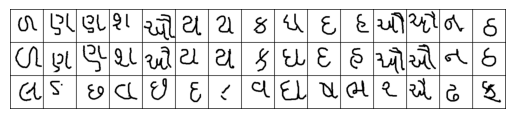

Anchor labels: [('character43', 'character29', 'character29', 'character45', 'character14', 'character40', 'character40', 'character15', 'character33', 'character32', 'character48', 'character14', 'character14', 'character34', 'character26')]


In [6]:
# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset, transform=transformation,test=False)
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=15)

# Extract one batch
example_batch = next(iter(vis_dataloader))
# Example batch is a list containing 3x11 images
concatenated = torch.cat((example_batch[0], example_batch[1], example_batch[2]),0)
imshow(torchvision.utils.make_grid(concatenated,nrow=15))
print(f"Anchor labels: {example_batch[3]}")


In [7]:
# Define the Triplet Loss Function
class TripletLoss(torch.nn.Module):
    def __init__(self, margin =d_margin):
        super(TripletLoss, self).__init__()
        self.margin = margin
    
    def forward(self, anchor, positive, negative):
        #Calculate the eucidian distance and calculate the Triplet Loss
        distance_positive = F.pairwise_distance(anchor, positive, keepdim=True)
        distance_negative = F.pairwise_distance(anchor, negative, keepdim=True)

        loss_triplet = torch.mean(F.relu(distance_positive - distance_negative + self.margin))

        return loss_triplet

In [8]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset, transform=transformation, test=False)
train_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=d_batch_size)
net = SiameseNetwork(d_latent).to(device)
criterion = TripletLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005)

In [9]:
def test_accruracy(net):
    train_results = []
    labels = []
    net.eval()
    siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test, transform=transformation)
    # Create a simple dataloader just for simple visualization
    vis_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=d_batch_size)
    running_loss_test = []
    loss_history_test = []
    with torch.no_grad():
        for epoch in range(0,1):
            # Initialize the running loss
            # Iterate over the batches in the dataloader
            for i, (anchor_test, positive_test, negative_test, _) in enumerate(vis_dataloader):
                # Transfer images and labels to the device
                anchor_test, positive_test, negative_test = anchor_test.to(device), positive_test.to(device), negative_test.to(device)
    
                # Forward pass
                output_anchor_test, output_positive_test, output_negative_test = [net.forward_once(anchor_test), net.forward_once(positive_test), net.forward_once(negative_test)]
                # Calculate the triplet loss
                loss_triplet_test = criterion(output_anchor_test, output_positive_test, output_negative_test)
    
                # Update the running loss
                running_loss_test.append(loss_triplet_test.item())

        return(np.sum(running_loss_test)/len(running_loss_test))


In [10]:
counter = []
loss_history = [] 
iteration_no = 0
# Training loop
for epoch in range(d_no_epochs):
    # Initialize the running loss
    running_loss = 0.0

    # Initialize the start time for the epoch
    epoch_start_time = time.time()
    
    # Iterate over the batches in the dataloader
    for i, (anchor, positive, negative,_)  in enumerate(train_dataloader):
        # print(anchor,positive, negative, edgecase)
        """ """ # Transfer images and labels to the device
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output_anchor, output_positive, output_negative = net(anchor, positive, negative)
        
        # Calculate the triplet loss
        loss_triplet = criterion(output_anchor, output_positive, output_negative)
        
        # Backward pass and optimization
        loss_triplet.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss_triplet.item()

        # Print the loss every 10 batches
        if (i + 1) % len(train_dataloader) == 0:
            print(f"Epoch [{epoch+1}/{d_no_epochs}], Batch [{i+1}/{len(train_dataloader)}], Loss: {running_loss / len(train_dataloader)}")
            running_loss = 0.0
        
        iteration_no += 1
        
        loss_history.append(loss_triplet.item())
        counter.append(iteration_no)

    # End of epoch
    # Calculate the epoch running time
    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time

    # Print epoch summary

Epoch [1/25], Batch [26/26], Loss: 1.4495732325773973
Epoch [2/25], Batch [26/26], Loss: 0.8401861786842346
Epoch [3/25], Batch [26/26], Loss: 0.7262822538614273
Epoch [4/25], Batch [26/26], Loss: 0.6518398431631235
Epoch [5/25], Batch [26/26], Loss: 0.6594263487137281
Epoch [6/25], Batch [26/26], Loss: 0.5481018687670047
Epoch [7/25], Batch [26/26], Loss: 0.6452113619217505
Epoch [8/25], Batch [26/26], Loss: 0.5351400203429736
Epoch [9/25], Batch [26/26], Loss: 0.46492387182437456
Epoch [10/25], Batch [26/26], Loss: 0.3763272716448857
Epoch [11/25], Batch [26/26], Loss: 0.44104019781717885
Epoch [12/25], Batch [26/26], Loss: 0.3794101189392117
Epoch [13/25], Batch [26/26], Loss: 0.43128041464548844
Epoch [14/25], Batch [26/26], Loss: 0.4357595850641911
Epoch [15/25], Batch [26/26], Loss: 0.3827851629601075
Epoch [16/25], Batch [26/26], Loss: 0.36996998809851134
Epoch [17/25], Batch [26/26], Loss: 0.319544996206577
Epoch [18/25], Batch [26/26], Loss: 0.33842298483404404
Epoch [19/25], 

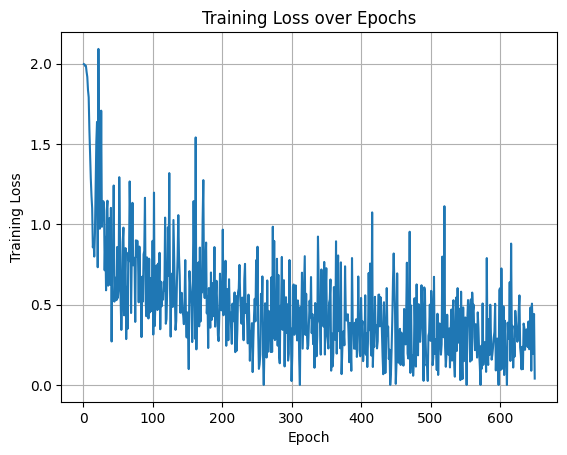

Training finished.


In [11]:
# Training complete
plt.plot(counter, loss_history)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()
print("Training finished.")

## Training complete
#plt.plot(test_history)
#plt.xlabel('Epoch')
#plt.ylabel('Testing Loss')
#plt.title('Testing Loss over Epochs')
#plt.grid(True)
#plt.show()
#print("Training finished.")


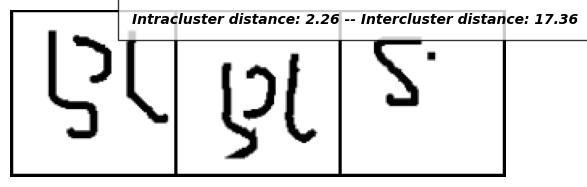

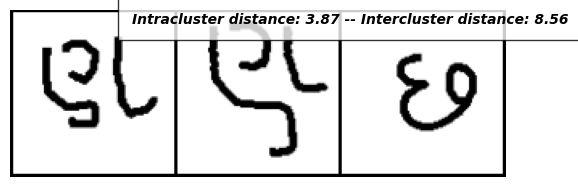

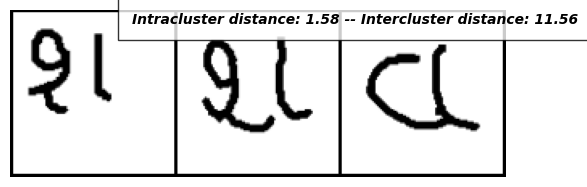

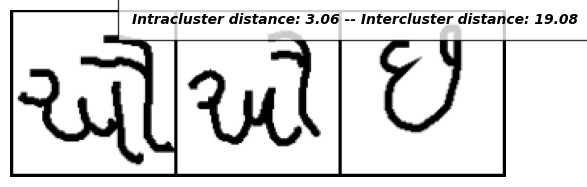

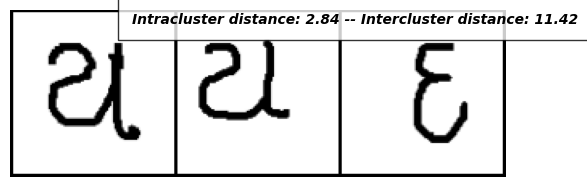

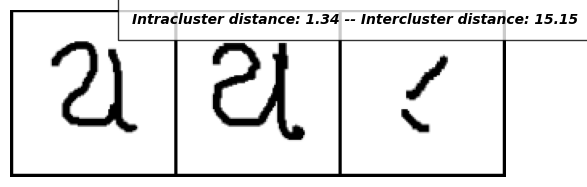

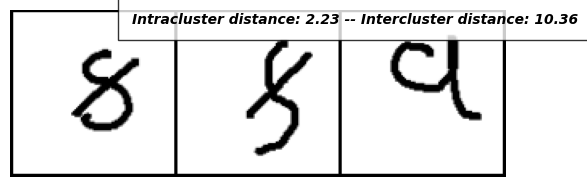

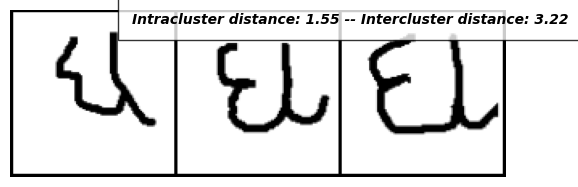

tensor([[ 5.1208e+00, -2.8418e+00,  1.5537e+01, -4.7461e-01,  1.4750e+00,
         -1.6738e+00,  1.7718e+00,  1.5307e+00, -1.5591e+00,  3.8283e+00,
          1.3304e+01, -5.4525e+00, -1.2953e+00,  7.4396e-01, -1.1482e+01,
          3.1282e-01,  2.8007e+00, -5.4092e+00,  3.9407e-01,  5.0429e-01,
         -4.4044e-01,  1.8830e+00,  6.8521e+00, -1.1303e+00, -4.7124e-03,
         -2.5899e-01,  5.9428e-01,  5.8489e+00,  3.3849e+00,  2.9312e+00,
          6.9374e+00,  9.8572e+00,  7.5506e+00,  5.6699e+00, -1.2372e+01,
         -2.0827e-01,  3.5101e-02, -3.4478e+00,  1.5126e+00, -1.2031e-04,
          4.9363e+00, -8.2953e-01,  5.8209e-01,  7.2805e-01,  1.9448e+00,
         -8.8982e+00, -5.0115e-01,  6.7616e-01,  2.1515e+00, -1.6841e-01,
         -3.5262e+00,  3.3627e-01, -1.3449e+01,  9.8738e-01,  2.8126e+00,
         -2.3664e-01,  1.6518e-02, -2.5641e+00, -4.8711e-01,  5.2470e-01,
          2.2797e+00, -3.9486e+00,  5.9884e+00,  1.8044e-02,  6.7247e-03,
         -3.8052e-01, -1.9085e+00,  5.

In [12]:
# Load it into the SiameseNetworkDataset

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
anchor, positive, negative, _ = next(dataiter)

for i in range(8):
    # Iterate over 10 images and test them with the first image (x0)
    anchor, positive, negative, _ = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((anchor, positive, negative), 0)
    
    output_anchor, output_positive, output_negative = net(anchor.to(device), positive.to(device), negative.to(device))
    euclidean_distance_positive = F.pairwise_distance(output_anchor, output_positive)
    euclidean_distance_negative = F.pairwise_distance(output_anchor, output_negative)
    imshow(torchvision.utils.make_grid(concatenated), f'Intracluster distance: {euclidean_distance_positive.item():.2f} -- Intercluster distance: {euclidean_distance_negative.item():.2f}')


Save Parameters


In [13]:
#torch.save({"model_state_dict": net.state_dict(),"optimizer_state_dict": optimizer.state_dict()}, "trained_model.pth")

Visualization of Latent space

In [14]:
if d_latent == 2:
    plot_batch = 10
    train_results = []
    labels = []
    net.eval()
    siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                            transform=transformation)
    # Create a simple dataloader just for simple visualization
    vis_dataloader = DataLoader(siamese_dataset,
                            shuffle=True,
                            batch_size=d_batch_size)


    with torch.no_grad():
        for i,batch in enumerate(vis_dataloader):
            if i >= plot_batch:
                break
            anchor, _, _, label = batch
            anchor = anchor.to(device)
            output_anchor = net.forward_once(anchor)
            train_results.append(output_anchor.cpu().numpy())
            labels.append(label[0])

    train_results = np.concatenate(train_results)
    labels = np.concatenate(labels)
    labels=np.array(labels)
    combined_data = list(zip(train_results,labels))

    cmap = plt.cm.get_cmap('brg', len(np.unique([point[1] for point in combined_data])))
    fig = plt.figure()
    ax = fig.add_subplot()
    for label in enumerate(np.unique([point[1] for point in combined_data])):
        points = [data[0] for data in combined_data if data[1]==label[1]]
        ax.scatter([point[0] for point in points], [point[1] for point in points], c=cmap(label[0]), label=label[1],s =  0.5)
        points = np.concatenate(points)
        points=points.reshape(-1,2)
        group_means = np.mean(points,axis=0)
        group_std = np.std(points, axis=0)
        group_range = np.ptp(points, axis=0)
        # Plot the mean as a center point
        ax.plot(group_means[0], group_means[1],marker ="*", color=cmap(label[0]))


    ax.grid(True)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Embeddings trainig set in Latent Space')
    plt.legend(loc=(1.1, 0))

Defining the threshold by datat distribution of positive and negative distance for classification

760


,Pos Dist,Neg Dist
count,759.000000,759.000000
mean,2.353831,10.088330
std,1.394803,5.906230
min,0.076235,0.520354
25%,1.352426,5.615828
50%,2.142243,8.915307
75%,3.079373,13.542541
max,9.277042,36.248386


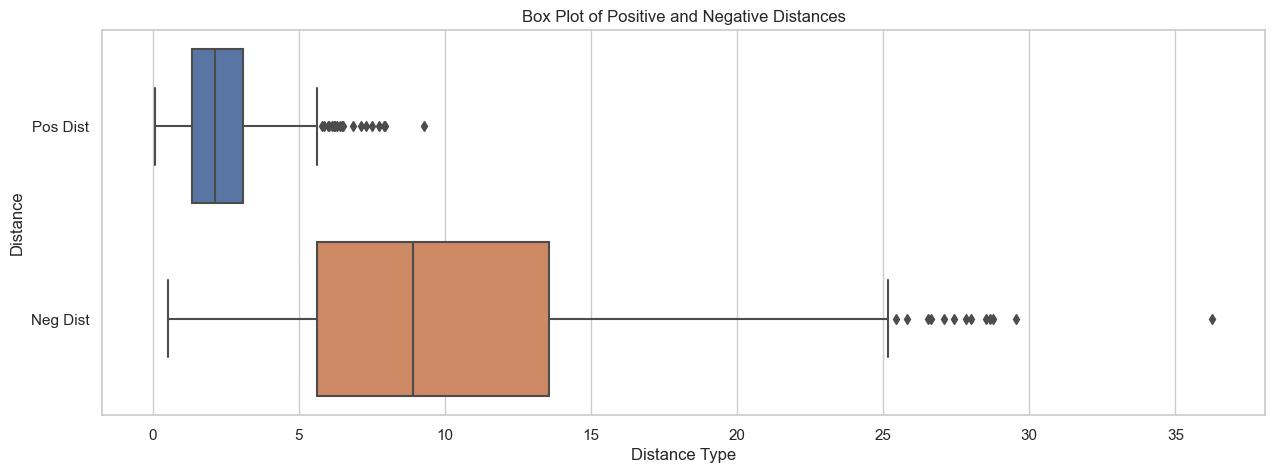

In [15]:
# Load it into the SiameseNetworkDataset

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset, transform=transformation)
train_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(train_dataloader)
anchor, positive, negative, _ = next(dataiter)
pos_dist = []
neg_dist = []
print(len(train_dataloader))
for i in range(len(train_dataloader)-1):
    # Iterate over 10 images and test them with the first image (x0)
    anchor, positive, negative, _ = next(dataiter)

    output_anchor, output_positive, output_negative = net.forward_once(anchor.to(device)), net.forward_once(positive.to(device)), net.forward_once(negative.to(device))
    euclidean_distance_positive = F.pairwise_distance(output_anchor, output_positive)
    euclidean_distance_negative = F.pairwise_distance(output_anchor, output_negative)
    # print(euclidean_distance_positive)
    pos_dist.append(euclidean_distance_positive.detach().cpu().numpy())
    neg_dist.append(euclidean_distance_negative.detach().cpu().numpy())

pos_dist = [x[0] for x in pos_dist]
neg_dist = [x[0] for x in neg_dist]

# Combine positive and negative distances for the box plot
distances = [pos_dist, neg_dist]

distance_data = {'Pos Dist':pos_dist,'Neg Dist':neg_dist}
df_train = pd.DataFrame(distance_data)
df_train.head()

# Set the style of the plot
sns.set(style="whitegrid")

# Create the box plot using seaborn
plt.figure(figsize=(15,5))
sns.boxplot(data=df_train,orient='h')

# Set the labels for x-axis and y-axis
plt.xlabel('Distance Type')
plt.ylabel('Distance')

# Set the title of the plot
plt.title('Box Plot of Positive and Negative Distances')

df_train.describe()

In [16]:
# Load it into the SiameseNetworkDataset

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test, transform=transformation,test = True)
test_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=True)

# Grab one image that we are going to test
net.eval()
dist_positive_test = []
print(len(test_dataloader))
dataiter = iter(test_dataloader)
with torch.no_grad():
    while True:
        try:
            anchor, positive, positive_test, _ = next(dataiter)

            output_anchor = net.forward_once(anchor.to(device))
            output_positive_test = net.forward_once(positive_test.to(device))
            distance_anchor_positive_test = F.pairwise_distance(output_anchor, output_positive_test)
            dist_positive_test.append(distance_anchor_positive_test.detach().cpu().numpy())
        except StopIteration:
            break


dist_positive_test = [x[0] for x in dist_positive_test]

# Combine positive and negative distances for the box plot
distances = [dist_positive_test]

distance_data = {'Pos Test Dist' :dist_positive_test}
df_test = pd.DataFrame(distance_data)
df_test.head()
print(f"Threshold: {df_train['Pos Dist'].quantile(0.875)}")
print(len(df_test[df_test['Pos Test Dist'] < df_train['Pos Dist'].quantile(0.875)])/len(df_test))

df_train.describe()

200
Threshold: 3.911463439464569
0.5797872340425532


,Pos Dist,Neg Dist
count,759.000000,759.000000
mean,2.353831,10.088330
std,1.394803,5.906230
min,0.076235,0.520354
25%,1.352426,5.615828
50%,2.142243,8.915307
75%,3.079373,13.542541
max,9.277042,36.248386


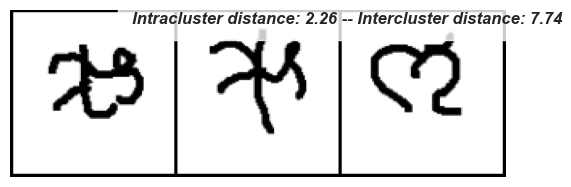

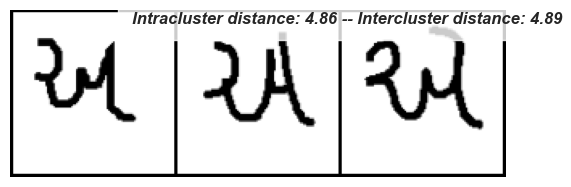

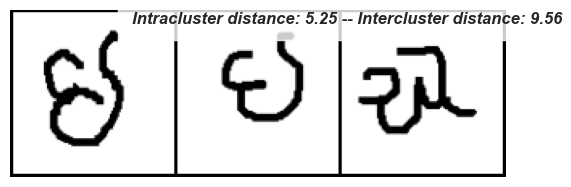

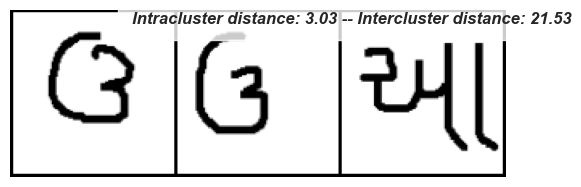

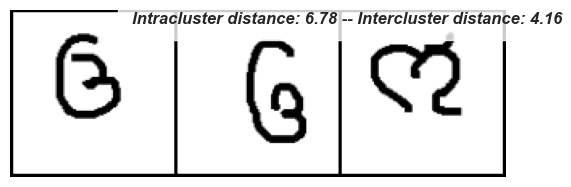

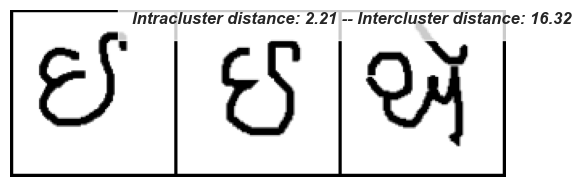

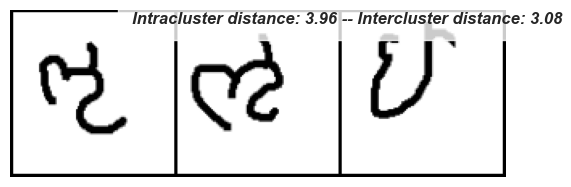

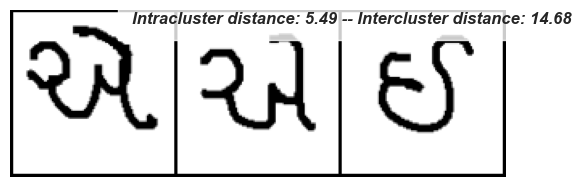

tensor([[ 6.8393e+00, -1.9108e+00,  2.1294e+01, -4.8400e-01,  1.9693e+00,
         -3.3061e+00,  2.1087e+00,  2.2178e+00, -1.7002e+00,  4.3740e+00,
          1.6896e+01, -7.5489e+00, -1.1536e+00,  9.1883e-01, -1.5634e+01,
          4.2007e-01,  3.6163e+00, -6.5283e+00, -4.7262e-02,  6.7160e-01,
         -9.6721e-01,  1.5528e+00,  8.2964e+00, -1.2739e+00, -4.0052e-02,
         -4.1684e-01,  1.1424e+00,  6.8004e+00,  3.7914e+00,  4.0840e+00,
          7.9698e+00,  1.2568e+01,  1.0120e+01,  8.4221e+00, -1.6010e+01,
         -2.1862e-01, -1.2488e+00, -3.9845e+00,  2.4429e+00, -2.4412e-02,
          8.0718e+00, -1.0451e+00,  6.3979e-01,  9.3086e-01,  3.0691e+00,
         -1.1506e+01, -5.2217e-01,  6.8675e-01,  2.6891e+00, -1.4013e-01,
         -5.3964e+00,  5.0502e-01, -1.6423e+01,  1.2285e+00,  4.0519e+00,
         -3.6712e-01,  2.6017e-02, -3.7064e+00, -5.9847e-01,  6.7409e-01,
          3.7983e+00, -4.6461e+00,  8.8109e+00,  1.8321e-02,  5.0159e-01,
         -5.4121e-01, -2.4390e+00,  7.

In [17]:
# Load it into the SiameseNetworkDataset

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
anchor, positive, negative, _ = next(dataiter)

for i in range(8):
    # Iterate over 10 images and test them with the first image (x0)
    anchor, positive, negative, _ = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((anchor, positive, negative), 0)
    
    output_anchor, output_positive, output_negative = net(anchor.to(device), positive.to(device), negative.to(device))
    euclidean_distance_positive = F.pairwise_distance(output_anchor, output_positive)
    euclidean_distance_negative = F.pairwise_distance(output_anchor, output_negative)
    imshow(torchvision.utils.make_grid(concatenated), f'Intracluster distance: {euclidean_distance_positive.item():.2f} -- Intercluster distance: {euclidean_distance_negative.item():.2f}')


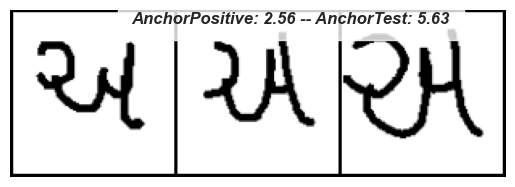

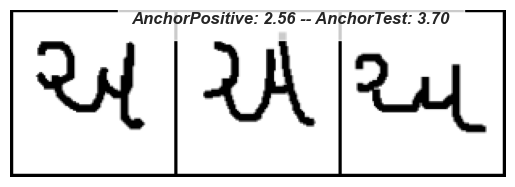

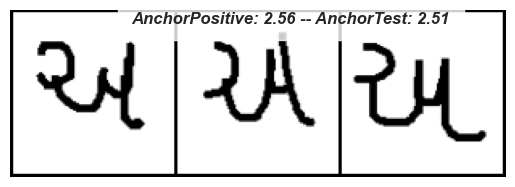

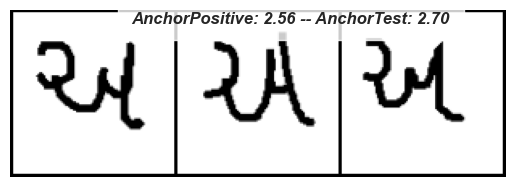

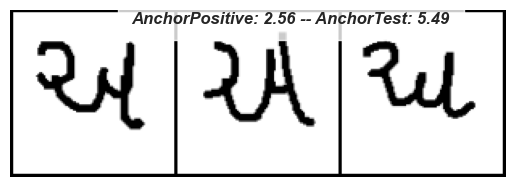

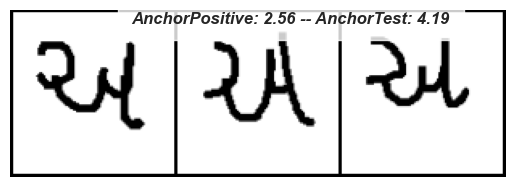

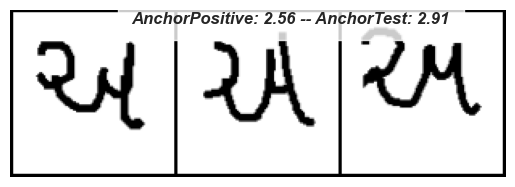

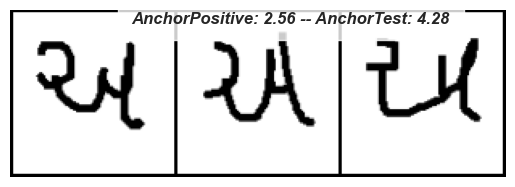

tensor([[ 6.5891e+00, -1.7837e+00,  2.0502e+01, -4.6745e-01,  1.8967e+00,
         -3.2070e+00,  2.0262e+00,  2.1438e+00, -1.6284e+00,  4.1940e+00,
          1.6240e+01, -7.2680e+00, -1.0985e+00,  8.8832e-01, -1.5059e+01,
          3.9882e-01,  3.4796e+00, -6.2685e+00, -5.4848e-02,  6.4841e-01,
         -9.4081e-01,  1.4801e+00,  7.9685e+00, -1.2283e+00, -3.6007e-02,
         -3.9435e-01,  1.1075e+00,  6.5303e+00,  3.6190e+00,  3.9396e+00,
          7.6311e+00,  1.2083e+01,  9.7338e+00,  8.1223e+00, -1.5396e+01,
         -2.0798e-01, -1.2371e+00, -3.8202e+00,  2.3687e+00, -2.4793e-02,
          7.8030e+00, -1.0086e+00,  6.0780e-01,  8.9623e-01,  2.9617e+00,
         -1.1064e+01, -5.0344e-01,  6.5384e-01,  2.5844e+00, -1.3495e-01,
         -5.2086e+00,  4.9291e-01, -1.5759e+01,  1.1925e+00,  3.9095e+00,
         -3.6403e-01,  2.6921e-02, -3.5754e+00, -5.7764e-01,  6.5369e-01,
          3.6732e+00, -4.4549e+00,  8.4991e+00,  1.0374e-02,  4.9871e-01,
         -5.2173e-01, -2.3357e+00,  7.

In [18]:
# Load it into the SiameseNetworkDataset

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation, test= True)
test_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
anchor, positive, negative, _ = next(dataiter)

for i in range(8):
    # Iterate over 10 images and test them with the first image (x0)
    anchor, positive, negative, _ = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((anchor, positive, negative), 0)
    
    output_anchor, output_positive, output_negative = net(anchor.to(device), positive.to(device), negative.to(device))
    euclidean_distance_positive = F.pairwise_distance(output_anchor, output_positive)
    euclidean_distance_negative = F.pairwise_distance(output_anchor, output_negative)
    imshow(torchvision.utils.make_grid(concatenated), f'AnchorPositive: {euclidean_distance_positive.item():.2f} -- AnchorTest: {euclidean_distance_negative.item():.2f}')